In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oral-cancer-images-for-classification/dataset/Oral Cancer photos/266.jpeg
/kaggle/input/oral-cancer-images-for-classification/dataset/Oral Cancer photos/071.jpeg
/kaggle/input/oral-cancer-images-for-classification/dataset/Oral Cancer photos/344.jpeg
/kaggle/input/oral-cancer-images-for-classification/dataset/Oral Cancer photos/images (4).jpeg
/kaggle/input/oral-cancer-images-for-classification/dataset/Oral Cancer photos/228.jpeg
/kaggle/input/oral-cancer-images-for-classification/dataset/Oral Cancer photos/099.jpeg
/kaggle/input/oral-cancer-images-for-classification/dataset/Oral Cancer photos/photo_2025-01-26_17-29-59.jpg
/kaggle/input/oral-cancer-images-for-classification/dataset/Oral Cancer photos/130.jpeg
/kaggle/input/oral-cancer-images-for-classification/dataset/Oral Cancer photos/ircmj-17-3-13478-g001-preview.png
/kaggle/input/oral-cancer-images-for-classification/dataset/Oral Cancer photos/lip-cancer-and-symptoms.jpg
/kaggle/input/oral-cancer-images-for-classificat

In [2]:
# Core
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Image processing
import cv2
from PIL import Image

In [4]:
# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)


In [5]:

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

2025-12-29 11:17:04.182332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767007024.370117      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767007024.425747      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767007024.873605      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767007024.873644      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767007024.873647      55 computation_placer.cc:177] computation placer alr

In [6]:
# Warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
import os

BASE_PATH = "/kaggle/input/oral-cancer-images-for-classification/dataset"

oral_cancer_path = os.path.join(BASE_PATH, "Oral Cancer photos")
normal_path = os.path.join(BASE_PATH, "normal")

print("Oral Cancer images:", len(os.listdir(oral_cancer_path)))
print("Normal images:", len(os.listdir(normal_path)))


Oral Cancer images: 685
Normal images: 553


In [8]:
import os

DATASET_PATH = "/kaggle/input/oral-cancer-images-for-classification/dataset"

print("Folders in dataset:")
print(os.listdir(DATASET_PATH))


Folders in dataset:
['Oral Cancer photos', 'normal']


In [9]:
## Dataset Path & Labels
CATEGORIES = ["normal", "Oral Cancer photos"]  # match exact folder names
DATASET_PATH = "/kaggle/input/oral-cancer-images-for-classification/dataset"
IMG_SIZE = 224




In [10]:
## Load & Preprocess Images
def load_images(dataset_path, categories, img_size):
    images, labels = [], []

    for label, category in enumerate(categories):
        folder = os.path.join(dataset_path, category)
        print(f"Loading images from {folder} ...")
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size))
                img = img / 255.0
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Skipped {img_name}: {e}")

    return np.array(images), np.array(labels)

X, y = load_images(DATASET_PATH, CATEGORIES, IMG_SIZE)

print("\nFinal dataset shape:")
print("Images:", X.shape)
print("Labels:", y.shape)
      

Loading images from /kaggle/input/oral-cancer-images-for-classification/dataset/normal ...


libpng warning: iCCP: extra compressed data


Loading images from /kaggle/input/oral-cancer-images-for-classification/dataset/Oral Cancer photos ...


libpng warning: iCCP: extra compressed data
libpng warning: iCCP: extra compressed data



Final dataset shape:
Images: (1238, 224, 224, 3)
Labels: (1238,)


In [11]:
## Verify class distribution 
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(553), np.int64(1): np.int64(685)}


In [12]:
## Train / Test Validation split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [13]:
## Data Augmenttation
train_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator()


In [14]:
## Feature Extraction for ML Models (VGG16)
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(224,224,3))
base_model.trainable = False

def extract_features(images):
    features = base_model.predict(images, verbose=0)
    return features.reshape(features.shape[0], -1)

X_train_feat = extract_features(X_train)
X_test_feat = extract_features(X_test)


I0000 00:00:1767007174.873461      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767007174.877435      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1767007178.685125     129 service.cc:152] XLA service 0x7b3528009d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767007178.685162     129 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767007178.685166     129 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767007178.850087     129 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767007190.950862     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [15]:
## ML Models
## SVM
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train_feat, y_train)

svm_pred = svm.predict(X_test_feat)


In [16]:
## Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_feat, y_train)

rf_pred = rf.predict(X_test_feat)


In [19]:
## KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_feat, y_train)

knn_pred = knn.predict(X_test_feat)


In [24]:
## Model evaluation function
def evaluate_model(y_true, y_pred, model_name):
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Create results table
    results_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall (Sensitivity)", "F1-score"],
        "Score": [acc, prec, rec, f1]
    })

    print(f"\n Model Performance: {model_name}")
    display(results_df)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Normal", "Oral Cancer"],
        yticklabels=["Normal", "Oral Cancer"]
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()




 Model Performance: SVM


,Metric,Score
0,Accuracy,0.887097
1,Precision,0.847458
2,Recall (Sensitivity),0.970874
3,F1-score,0.904977


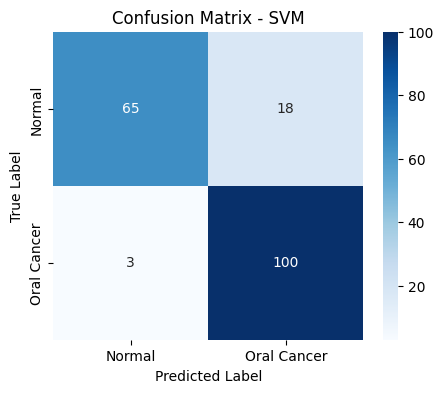

In [25]:
evaluate_model(y_test, svm_pred, "SVM")


 Model Performance: Random Forest


,Metric,Score
0,Accuracy,0.876344
1,Precision,0.857143
2,Recall (Sensitivity),0.932039
3,F1-score,0.893023


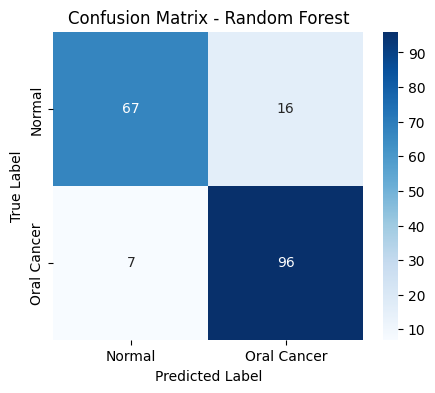

In [26]:
evaluate_model(y_test, rf_pred, "Random Forest")


 Model Performance: KNN


,Metric,Score
0,Accuracy,0.833333
1,Precision,0.918605
2,Recall (Sensitivity),0.766990
3,F1-score,0.835979


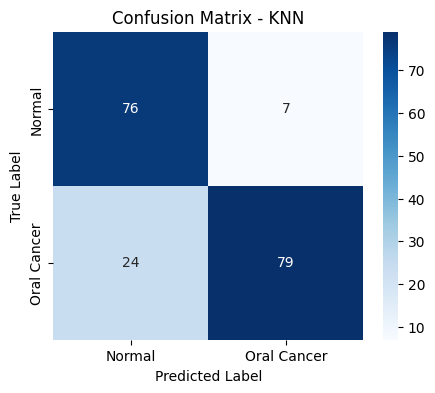

In [27]:
evaluate_model(y_test, knn_pred, "KNN")

In [28]:
def compare_models(results):
    df = pd.DataFrame(results)
    return df.set_index("Model")

results = []

for name, pred in zip(
    ["SVM", "Random Forest", "KNN"],
    [svm_pred, rf_pred, knn_pred]
):
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1-score": f1_score(y_test, pred)
    })

compare_models(results)


,Accuracy,Precision,Recall,F1-score
Model,,,,
SVM,0.887097,0.847458,0.970874,0.904977
Random Forest,0.876344,0.857143,0.932039,0.893023
KNN,0.833333,0.918605,0.766990,0.835979


## CNN (Transfer Learning – VGG16)

In [29]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)


In [30]:
cnn_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [31]:
## Train CNN
history = cnn_model.fit(
    train_gen.flow(X_train, y_train, batch_size=32),
    validation_data=val_gen.flow(X_val, y_val),
    epochs=20
)



Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 494ms/step - accuracy: 0.5812 - loss: 0.8075 - val_accuracy: 0.8280 - val_loss: 0.4543
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step - accuracy: 0.7384 - loss: 0.5355 - val_accuracy: 0.8495 - val_loss: 0.3724
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 391ms/step - accuracy: 0.8562 - loss: 0.3503 - val_accuracy: 0.8710 - val_loss: 0.3503
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 385ms/step - accuracy: 0.8205 - loss: 0.3848 - val_accuracy: 0.8710 - val_loss: 0.3363
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 380ms/step - accuracy: 0.8415 - loss: 0.3794 - val_accuracy: 0.8925 - val_loss: 0.3104
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 371ms/step - accuracy: 0.8914 - loss: 0.3123 - val_accuracy: 0.8871 - val_loss: 0.2915
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 371ms/step - accuracy: 0.8839 - loss: 0.2916 - val_accuracy: 0.8495 - val_loss: 0.3139
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step - accuracy: 0.8530 - loss: 0.3527 - val_accu

In [32]:
## CNN evaluation
cnn_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, cnn_pred))
print(confusion_matrix(y_test, cnn_pred))


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step
              precision    recall  f1-score   support

           0       0.92      0.84      0.88        83
           1       0.88      0.94      0.91       103

    accuracy                           0.90       186
   macro avg       0.90      0.89      0.90       186
weighted avg       0.90      0.90      0.90       186

[[70 13]
 [ 6 97]]


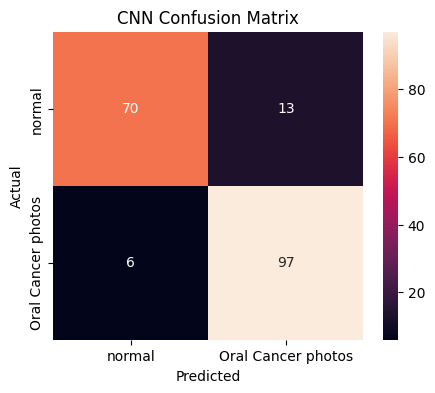

In [33]:
cm = confusion_matrix(y_test, cnn_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=CATEGORIES,
            yticklabels=CATEGORIES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CNN Confusion Matrix")
plt.show()


In [36]:
cnn_model.get_layer("vgg16").summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [46]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

# Input
inputs = Input(shape=(224,224,3))

# Base VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False

# Custom layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Functional model
cnn_model = Model(inputs, outputs)
cnn_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Explainable AI 

In [50]:
def grad_cam_functional(model, img_array, last_conv_layer_name="block5_conv3"):
    """
    Grad-CAM for Functional CNN models.
    """
    # Build gradient model
    grad_model = Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    # Compute gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # ReLU + Normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    return heatmap   # <-- remove .numpy()


In [51]:
def overlay_heatmap(heatmap, image, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_uint8 = np.uint8(image * 255)
    overlay = cv2.addWeighted(img_uint8, 1-alpha, heatmap, alpha, 0)
    return overlay


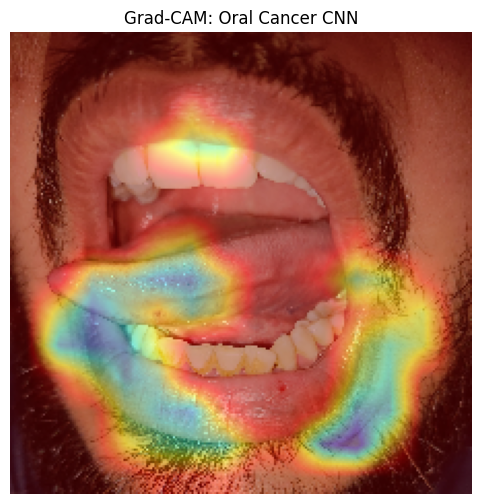

In [52]:
# Pick a test image
img = X_test[0]              # shape (224,224,3), normalized
img_input = np.expand_dims(img, axis=0)

# Grad-CAM
heatmap = grad_cam_functional(cnn_model, img_input, last_conv_layer_name="block5_conv3")

# Overlay
overlay_img = overlay_heatmap(heatmap, img)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(overlay_img)
plt.axis("off")
plt.title("Grad-CAM: Oral Cancer CNN")
plt.show()


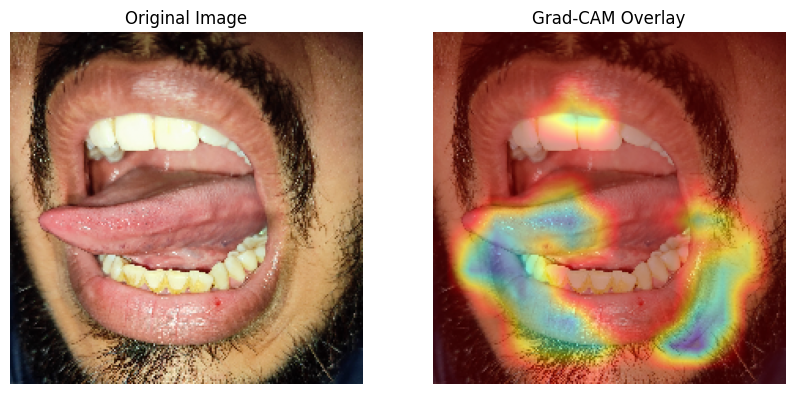

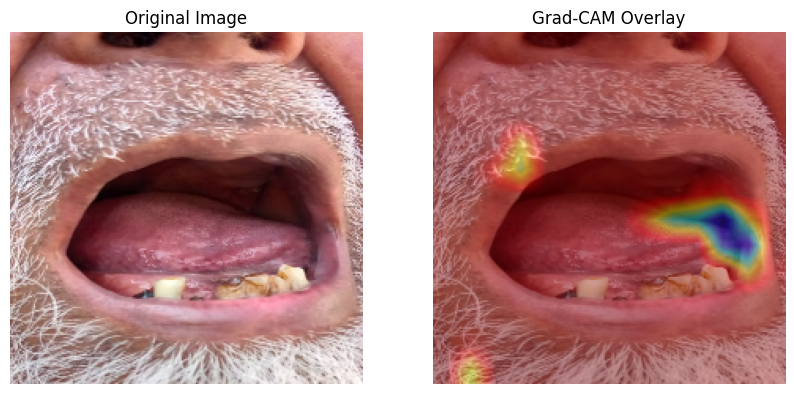

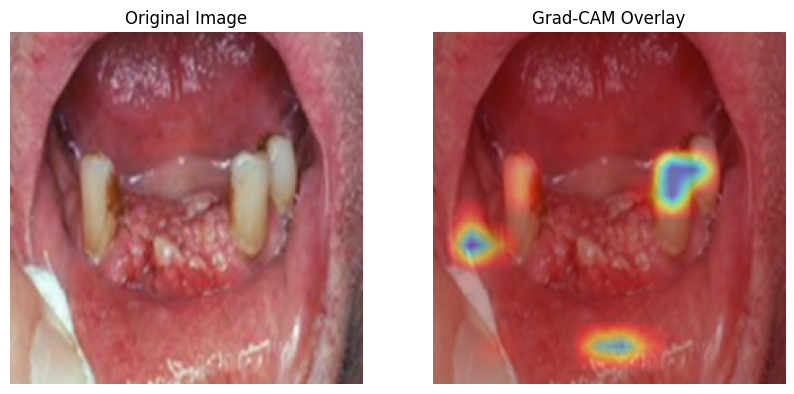

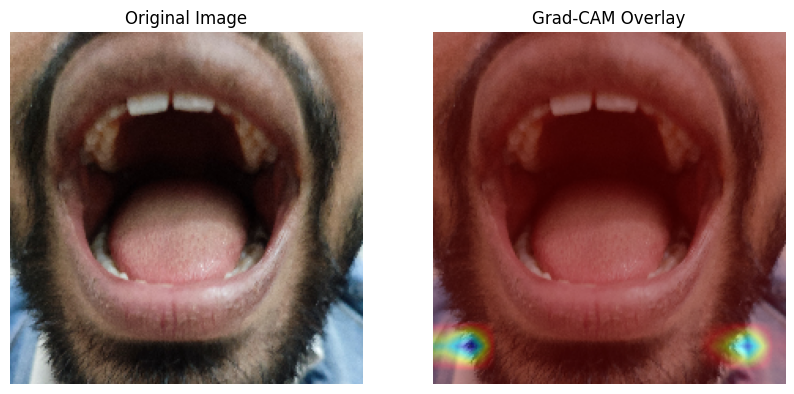

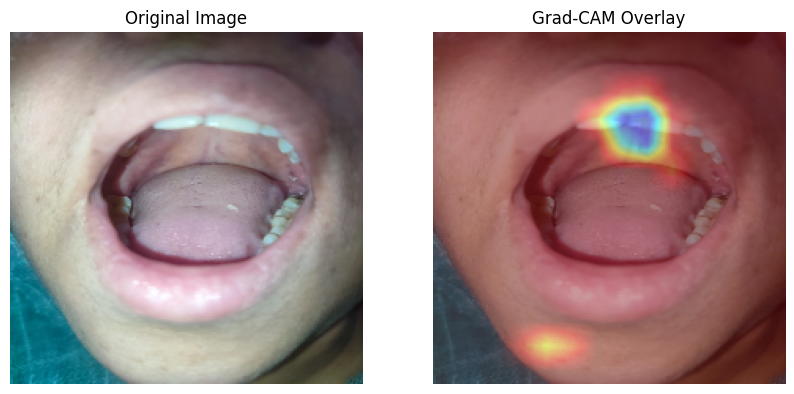

In [53]:
import matplotlib.pyplot as plt

num_images = 5   # Number of test images to visualize

for i in range(num_images):
    img = X_test[i]                      # normalized image (0-1)
    img_input = np.expand_dims(img, axis=0)

    # Grad-CAM heatmap
    heatmap = grad_cam_functional(cnn_model, img_input, last_conv_layer_name="block5_conv3")
    
    # Overlay heatmap on original image
    overlay_img = overlay_heatmap(heatmap, img)
    
    # Plot side by side
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.title("Grad-CAM Overlay")
    plt.imshow(overlay_img)
    plt.axis("off")
    
    plt.show()
